# STARDUST interactive

This Jupyter Notebook provides an interactive version of STARDUST signal extraction. Functions are defined and imported from util.py. Use help() to see the documentation. For a more detailed description of the STARDUST pipeline, please see the biorxiv paper and github page for more information. 

## 1. Environment set up

In [1]:
import os, scipy, sys, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from util import * # import functions from util.py

## 2. Data input

In [2]:
# input input and output directories
input_dir = input('Enter the path to the folder containing the input files: ')
output_dir = input('Enter the path to the folder containing the output files: ')

In [3]:
# input metadata related to the experiment
keyword = input('Enter the common keyword in input file (csv, ROA mask and cell mask) names: ')
drug_frame = float(input('Enter the frame number of drug application (enter 0 if no drug was applied): '))
frame_rate = float(input("Enter the frame rate (in Hz) of the recording (e.g. 1): "))
spatial_resolution = float(input('Enter the spatial resolution of the recording (in µm/pixel): '))
output_filename = input('Enter the output file name: ')
output_path = os.path.join(output_dir, output_filename)

Find input file paths using find_files(). Note that the current code assumes that the input time-series data is stored in a csv, and ends with "signals.csv", the ROA mask is stored as a tiff file with keyword "ROA", and similarly the cell mask is a tiff file with keyword "cell". 

You can also directly input the paths. 

In [4]:
# find the input files using find_files function
csv_path, ROA_mask_path, cell_mask_path = find_files(input_dir, keyword)

Found the following files: 

CSV file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_signal.csv
ROA mask:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_10to12_roamask.tif
Cell mask:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_10to12_cellmask.tif


Next, read in ROA mask and cell mask. 

Reading in file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_10to12_roamask.tif
This ROA mask contains 1302 ROAs.


Reading in file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_10to12_cellmask.tif
This cell mask contains 79 cells.




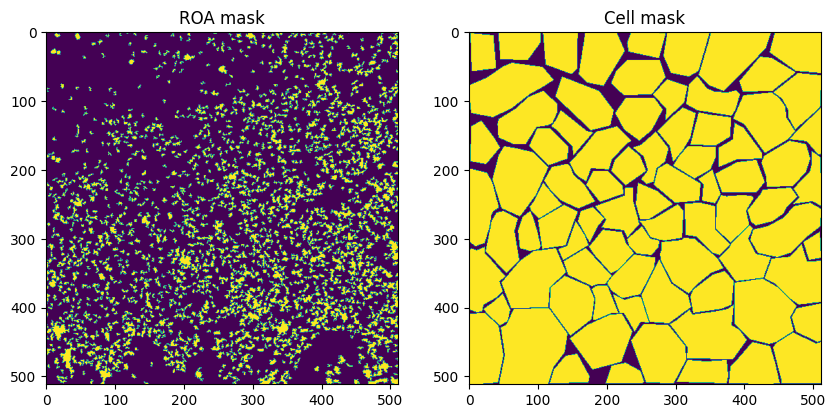

In [5]:
ROA_map_array, ROA_map_labeled, ROA_map_count = read_tif(ROA_mask_path, "ROA")
cell_map_array, cell_map_labeled, cell_count = read_tif(cell_mask_path, "cell")

visualize_map(ROA_map_array, cell_map_array)

## 3. Signal preprocessing

In [81]:
help(raw_to_filtered)

Help on function raw_to_filtered in module util:

raw_to_filtered(csv_path, order=4, cutoff=0.4)
    read in and convert raw traces to filtered traces



In [6]:
# Smooth traces using a filter
raw_traces, filtered_traces = raw_to_filtered(csv_path)

Reading in file:  /Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/20240409_slice0_recording1_ttx_200nm ne_signal.csv 


Applying a lowpass Butterworth filter with a 4 th order filter at the cutoff of 0.4 Hz


In [7]:
ROA_count, frame_count = check_traces(filtered_traces)

The current file contains: 
Number of ROA:  1302
Number of frames:  635


### Optinal: Signal correction using linear regression

This optional step uses the correct_shift() function to detect and correct gradual linear drift in the traces. Ideally, the slope distribution histogram should roughly center around zero. If the distribution is not centered around zero, it might indicate photobleaching or a significant z drift during the recording. 

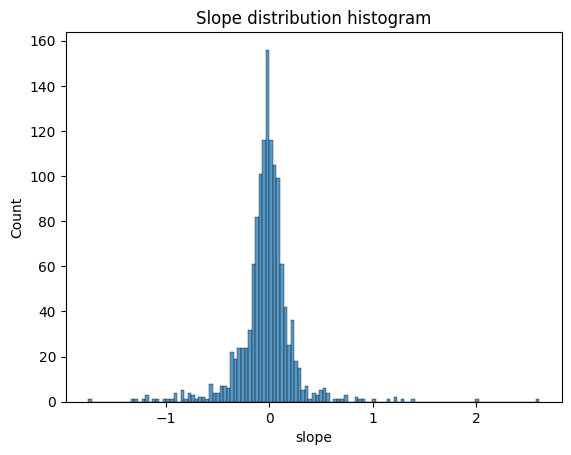

In [8]:
# optional: correct traces for shift using linear regression
corrected_traces, reg = correct_shift(filtered_traces)

## 4. Baseline determination and signal detection

In [20]:
help(iterative_baseline)

Help on function iterative_baseline in module util:

iterative_baseline(traces, signal_frames=None, baseline_start=0, baseline_end=-1)
    determine the bassline iteratively

    Args:
    traces: a two-dimensional array of traces
    signal_frames: optional, a two-dimensional boolean array corresponding to each ROA and each frame, true if frame is considered as signal
    baseline_start: optional, the starting frame for baseline calculation, default 0 (beginning of the recording)
    baseline_end: optional, the ending frame for baseline calculation, default -1 (end of the recording)

    Prompted inputs:
    n_iteration: number of iterations for signal detection
    signal_threshold: signal_threshold * dF/F baseline SD as signal threshold

    Returns:
    dff_traces: a two-dimensional array of delta F/F trace based on the provided thresholds
    baselines: a one-dimensional array of baseline values
    thresholds: a one-dimensional array of signal thresholds
    signal_frames: a two-

In [9]:
# baseline determination
dff_traces, baselines, thresholds, signal_frames, signal_boundaries, signal_threshold = iterative_baseline(corrected_traces)

Using signal threshold of 3.0* SD and detecting baseline from frame 0 to -1.

Processing round 1 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49

Processing round 2 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49

Processing round 3 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49

Processing round 4 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49

Processing round 5 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49

Processing round 6 of signal detection...
ROAs with signal:  1253
ROAs without signal:  49



## Checkpoint 1: dF/F traces heatmap

Visualze dF/F traces using heatmap. Each row represents one ROA and each column represents one frame.  

Note that for heatmap coloring, *vmin* is set at 0, and *vmax* is set at (signal_threshold + 2) * average thresholds across all ROAs. For example, if the signal_threshold is set at 3SD, any transients that has a dF/F value above baseline + 5SD will be colored red to facilitate visualization. You can adjust the vmax parameter if needed. 

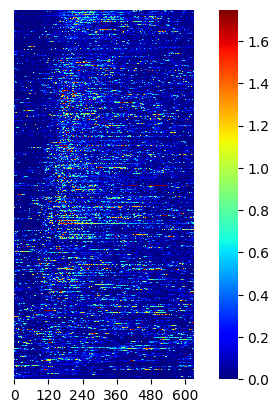

In [10]:
sns.heatmap(dff_traces, vmin = 0, vmax = (signal_threshold + 2) * thresholds.mean(), 
            xticklabels=120, yticklabels= False, cmap = 'jet', square = True);

## 5. Signal feature extraction

In [11]:
signal_stats = analyze_signal(dff_traces, signal_frames, signal_boundaries, frame_rate, drug_frame)

In [12]:
signal_stats.head()

,ROA_ID,signal_start_frame,signal_start_time,signal_end_frame,signal_end_time,peak_frame,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,epoch
0,1,142,133.270321,180,169.187146,156,147.448015,14.847157,0.799995,2.789360,5.797890,18.558842,0.376448,35.916824,NaN,drug
1,1,199,187.145558,230,216.446125,208,196.597353,3.908254,0.357832,1.247661,2.728721,18.041593,0.165543,29.300567,17.958412,drug
2,1,359,338.374291,365,344.045369,361,341.209830,0.889031,0.316584,1.103839,2.111177,2.025935,0.131466,5.671078,121.928166,drug
3,1,421,396.975425,458,431.947070,429,405.482042,7.006617,0.417606,1.456075,6.928630,25.356813,0.190193,34.971645,52.930057,drug
4,1,501,472.589792,518,488.657845,503,475.425331,2.171998,0.334066,1.164793,1.427344,12.529198,0.144102,16.068053,40.642722,drug


## 6. ROA and cell assignment

In [14]:
def align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count, spatial_resolution):
    ''' 
    aline ROA_ID and cell_ID based on the labeled map and returns a dataframe with ROA and cell alignment
    '''

    ROA = range(1, ROA_map_count+1)
    ROA_cell = []
    ROA_not_assigned = []
    size_pixel = []

    for i_ROA in ROA:
        # find the size of the ROA in number of pixels
        i_size = np.sum(ROA_map_labeled == i_ROA) 
        size_pixel.append(i_size)
        
        # find the most common cell ID assigned to the ROA
        cell_assigned = cell_map_labeled[ROA_map_labeled == i_ROA] # find corresponding cell ID for each pixel inside a ROA
        most_frequent = scipy.stats.mode(cell_assigned, keepdims = False).mode # find the most common cell ID inside the ROA
        if most_frequent == 0: # if the most common cell ID is 0, then find the second most common cell ID
            if len(np.unique(cell_assigned[cell_assigned != 0])) != 0:
                most_frequent = scipy.stats.mode(cell_assigned[cell_assigned != 0], axis = None).mode
            else:
                ROA_not_assigned.append(i_ROA)
        ROA_cell.append(most_frequent) # assign the most common cell ID for the ROA as its cell registration

    df_ROA_cell = pd.DataFrame({'ROA_ID': ROA, 'cell_ID': ROA_cell, 'size_pixel' : size_pixel})
    df_ROA_cell['size_um2'] = df_ROA_cell['size_pixel'] * spatial_resolution**2

    if len(ROA_not_assigned) != 0:
        print(f"There are {len(ROA_not_assigned)} ({round(len(ROA_not_assigned)/ROA_map_count * 100,2)}%) ROAs not assigned to any cell.")
        print("ROA IDs:", ROA_not_assigned)
        print("Please double check the cell mask registration. \n")
    print("ROA and cell alignment completed.")
    return df_ROA_cell


In [15]:
# add corresponding cell ID to the signal stats
df_ROA_cell = align_ROA_cell(ROA_map_labeled, cell_map_labeled, ROA_map_count, spatial_resolution)
signal_stats = pd.merge(df_ROA_cell, signal_stats, on = 'ROA_ID', how = 'right')

There are 8 (0.61%) ROAs not assigned to any cell.
ROA IDs: [333, 361, 423, 436, 449, 517, 721, 1278]
Please double check the cell mask registration. 

ROA and cell alignment completed.


In [16]:
signal_stats.head(10)

,ROA_ID,cell_ID,size_pixel,size_um2,signal_start_frame,signal_start_time,signal_end_frame,signal_end_time,peak_frame,peak_time,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration,inter_event_interval,epoch
0,1,1,13,10.158928,142,133.270321,180,169.187146,156,147.448015,14.847157,0.799995,2.789360,5.797890,18.558842,0.376448,35.916824,NaN,drug
1,1,1,13,10.158928,199,187.145558,230,216.446125,208,196.597353,3.908254,0.357832,1.247661,2.728721,18.041593,0.165543,29.300567,17.958412,drug
2,1,1,13,10.158928,359,338.374291,365,344.045369,361,341.209830,0.889031,0.316584,1.103839,2.111177,2.025935,0.131466,5.671078,121.928166,drug
3,1,1,13,10.158928,421,396.975425,458,431.947070,429,405.482042,7.006617,0.417606,1.456075,6.928630,25.356813,0.190193,34.971645,52.930057,drug
4,1,1,13,10.158928,501,472.589792,518,488.657845,503,475.425331,2.171998,0.334066,1.164793,1.427344,12.529198,0.144102,16.068053,40.642722,drug
5,1,1,13,10.158928,558,526.465028,583,550.094518,575,543.478261,3.420076,0.356281,1.242254,9.800179,5.140978,0.157776,23.629490,37.807183,drug
6,2,1,13,10.158928,150,140.831758,173,162.570888,162,153.119093,3.679908,0.443700,0.668742,9.820229,7.637337,0.206370,21.739130,NaN,drug
7,2,1,13,10.158928,278,261.814745,294,276.937618,286,270.321361,7.126801,1.292085,1.947424,6.894624,3.031089,0.608872,15.122873,99.243856,drug
8,2,1,13,10.158928,320,301.512287,333,313.799622,325,307.183365,3.311154,0.427407,0.644186,3.420234,4.091318,0.199172,12.287335,24.574669,drug
9,2,1,13,10.158928,367,345.935728,373,351.606805,369,348.771267,1.078603,0.358777,0.540746,2.070114,2.018801,0.164487,5.671078,32.136106,drug


### ROA based analysis

In [48]:
ROA_based, df_ROA_cell = ROA_analysis(signal_stats, df_ROA_cell, frame_count, frame_rate, drug_frame)

In [ ]:
ROA_based.head()

### Cell based analysis

In [43]:
cell_based = cell_analysis(signal_stats, df_ROA_cell)

In [44]:
cell_based.head()

,cell_ID,ROA_count,epoch,signal_count,AUC,amplitude,signal_to_noise,rise_time,decay_time,half_width,duration
0,0,8,baseline,5,7.391666,1.084641,3.944272,4.154566,6.599804,0.507310,17.958412
1,0,8,drug,83,10.070828,1.073803,3.345489,6.402445,6.922403,0.492391,23.356185
2,1,9,baseline,1,0.634379,0.224400,1.196389,1.670233,2.204720,0.105827,8.506616
3,1,9,drug,71,4.932047,0.647492,2.226412,4.130656,6.173720,0.294515,17.119732
4,2,18,baseline,6,1.320943,0.503707,1.947104,1.823957,1.725540,0.208164,5.356018


## Checkpoint 2: ROA stats

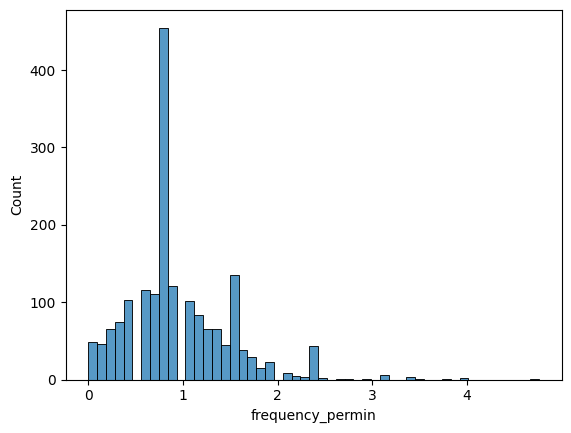

In [60]:
sns.histplot(data = ROA_based, x = 'frequency_permin');

In [50]:
ROA_summary = df_ROA_cell.groupby('ROA_type').count()
ROA_summary

,ROA_ID,cell_ID
ROA_type,,
inactive,49,49
on,733,733
stable,520,520


## Checkpoint 3: Individual traces
Use the inspect_trace() function to visualize traces. 

### Visualize inactive ROAs
The following example checks all ROAs that are "inactive" based on our pipeline but was intially determined as active ROA by AQuA. 

In [ ]:
inactive_ROAs = df_ROA_cell[df_ROA_cell['ROA_type'] == 'inactive']['ROA_ID'].to_list()
inspect_trace(inactive_ROAs, dff_traces, baselines, thresholds, drug_frame)

### Visualize ROAs with large slope during optional correction

In [ ]:
check_ROAs = pull_largeslope_traces(ROA_count, reg)
inspect_trace(check_ROAs, dff_traces, baselines, thresholds, drug_frame)

## 7. Data output

In [87]:
metadata = metadata_todf()
output_data(save_as = 'csv')

Saving outputs as csv files...
Outputs saved to/Users/mikodai/Library/CloudStorage/Box-Box/Calcium imaging analysis Miko/20240409/20240409_slice0_recording1_TTX_200nM NE/test.xlsx
